# Model 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

# Goals: 


The goal of this project is to have you complete a very common real-world task in regard to time series modeling. However, real world problems often come with a significant degree of ambiguity, which requires you to use your knowledge of statistics and data science to think critically about and answer. While the main task in this project is time series modeling, that isn't the overall goal -- it is important to understand that time series modeling is a tool in your toolbox, and the forecasts it provides you are what you'll use to answer important questions.

In short, to pass this project, demonstrating the quality and thoughtfulness of your overall recommendation is at least as important as successfully building a time series model!

In [24]:
#"The expectations of life depend upon diligence; the mechanic that would perfect his work must first sharpen his tools."
#- Confucius

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import xgboost as xgb

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, \
AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from statsmodels.tsa.stattools import adfuller

In [25]:
df = pd.read_csv('Data/zillow_data.csv')

In [26]:
df

#last columns are in a "Wide" format 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [28]:
df.info

<bound method DataFrame.info of        RegionID  RegionName                 City State              Metro  \
0         84654       60657              Chicago    IL            Chicago   
1         90668       75070             McKinney    TX  Dallas-Fort Worth   
2         91982       77494                 Katy    TX            Houston   
3         84616       60614              Chicago    IL            Chicago   
4         93144       79936              El Paso    TX            El Paso   
...         ...         ...                  ...   ...                ...   
14718     58333        1338             Ashfield    MA    Greenfield Town   
14719     59107        3293            Woodstock    NH          Claremont   
14720     75672       40404                Berea    KY           Richmond   
14721     93733       81225  Mount Crested Butte    CO                NaN   
14722     95851       89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996

In [29]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,...,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,...,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,...,3.603984e+05,3.614678e+05,3.627563e+05,3.644610e+05,3.656003e+05,3.670454e+05,3.695727e+05,3.717739e+05,3.724612e+05,3.720544e+05
min,58196.000000,1001.000000,1.000000,1.130000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,...,1.440000e+04,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04
25%,67174.500000,22101.500000,3681.500000,6.880000e+04,6.890000e+04,6.910000e+04,6.920000e+04,6.937500e+04,6.950000e+04,6.960000e+04,...,1.269000e+05,1.275000e+05,1.282000e+05,1.287000e+05,1.292500e+05,1.299000e+05,1.306000e+05,1.310500e+05,1.319500e+05,1.324000e+05
50%,78007.000000,46106.000000,7362.000000,9.950000e+04,9.950000e+04,9.970000e+04,9.970000e+04,9.980000e+04,9.990000e+04,9.995000e+04,...,1.884000e+05,1.896000e+05,1.905000e+05,1.914000e+05,1.925000e+05,1.934000e+05,1.941000e+05,1.950000e+05,1.967000e+05,1.981000e+05
75%,90920.500000,75205.500000,11042.500000,1.432000e+05,1.433000e+05,1.432250e+05,1.432250e+05,1.435000e+05,1.437000e+05,1.439000e+05,...,3.050000e+05,3.066500e+05,3.085000e+05,3.098000e+05,3.117000e+05,3.134000e+05,3.151000e+05,3.168500e+05,3.188500e+05,3.211000e+05
max,753844.000000,99901.000000,14723.000000,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,...,1.888990e+07,1.870350e+07,1.860530e+07,1.856940e+07,1.842880e+07,1.830710e+07,1.836590e+07,1.853040e+07,1.833770e+07,1.789490e+07


In [30]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

In [31]:
df.dropna()


#Opted for dropping na's because represent 13% loss of total and interpolation or forward/backward filling

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14716,99032,97028,Rhododendron,OR,Portland,Clackamas,14717,136200.0,136600.0,136800.0,...,332600,332900,335600,338900,340500,341000,342300,345000,348000,349300
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400


In [32]:
#[14723 rows x 272 columns]> / 12895 rows × 272 columns

melted_df = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
                    var_name='Date', value_name='MedianHousingSales')

# 'MedianHousingSales' contains corresponding values for each date and zipcode combination


In [33]:
melted_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MedianHousingSales
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04,77300.0
...,...,...,...,...,...,...,...,...,...
3901590,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,2018-04,209300.0
3901591,59107,3293,Woodstock,NH,Claremont,Grafton,14720,2018-04,225800.0
3901592,75672,40404,Berea,KY,Richmond,Madison,14721,2018-04,133400.0
3901593,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,2018-04,664400.0


In [34]:
# Reshape
reshaped_df = df.melt(id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
                      var_name='Date', value_name='MedianHousingSales')

#'Date' column to datetime format
reshaped_df['Date'] = pd.to_datetime(reshaped_df['Date'], format='%Y-%m')

# Pivot
final_df = reshaped_df.pivot_table(index=['Date', 'RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
                                   values='MedianHousingSales')

# Reset the index to make 'Date' and other columns separate columns
final_df = final_df.reset_index()

In [35]:
final_df

,Date,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MedianHousingSales
0,1996-04-01,58196,1001,Agawam,MA,Springfield,Hampden,5851,113100.0
1,1996-04-01,58197,1002,Amherst,MA,Springfield,Hampshire,4200,161000.0
2,1996-04-01,58200,1005,Barre,MA,Worcester,Worcester,11214,103100.0
3,1996-04-01,58201,1007,Belchertown,MA,Springfield,Hampshire,6851,133400.0
4,1996-04-01,58202,1008,Blandford,MA,Springfield,Hampden,14548,117500.0
...,...,...,...,...,...,...,...,...,...
3508676,2018-04-01,677175,84009,South Jordan,UT,Salt Lake City,Salt Lake,4654,413800.0
3508677,2018-04-01,698721,86005,Flagstaff,AZ,Flagstaff,Coconino,5836,393400.0
3508678,2018-04-01,738092,97003,Beaverton,OR,Portland,Washington,3950,344700.0
3508679,2018-04-01,753843,97703,Bend,OR,Bend,Deschutes,2804,581000.0


In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 24))

# Plotting
for region in final_df['RegionName'].unique():
    data = final_df[final_df['RegionName'] == region]
    plt.plot(data['Date'], data['MedianHousingSales'], label=region)

plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Median Housing Sales Over Time')
plt.legend()
plt.tight_layout()  # Ensures proper spacing of the plot elements
plt.show()

KeyboardInterrupt: 

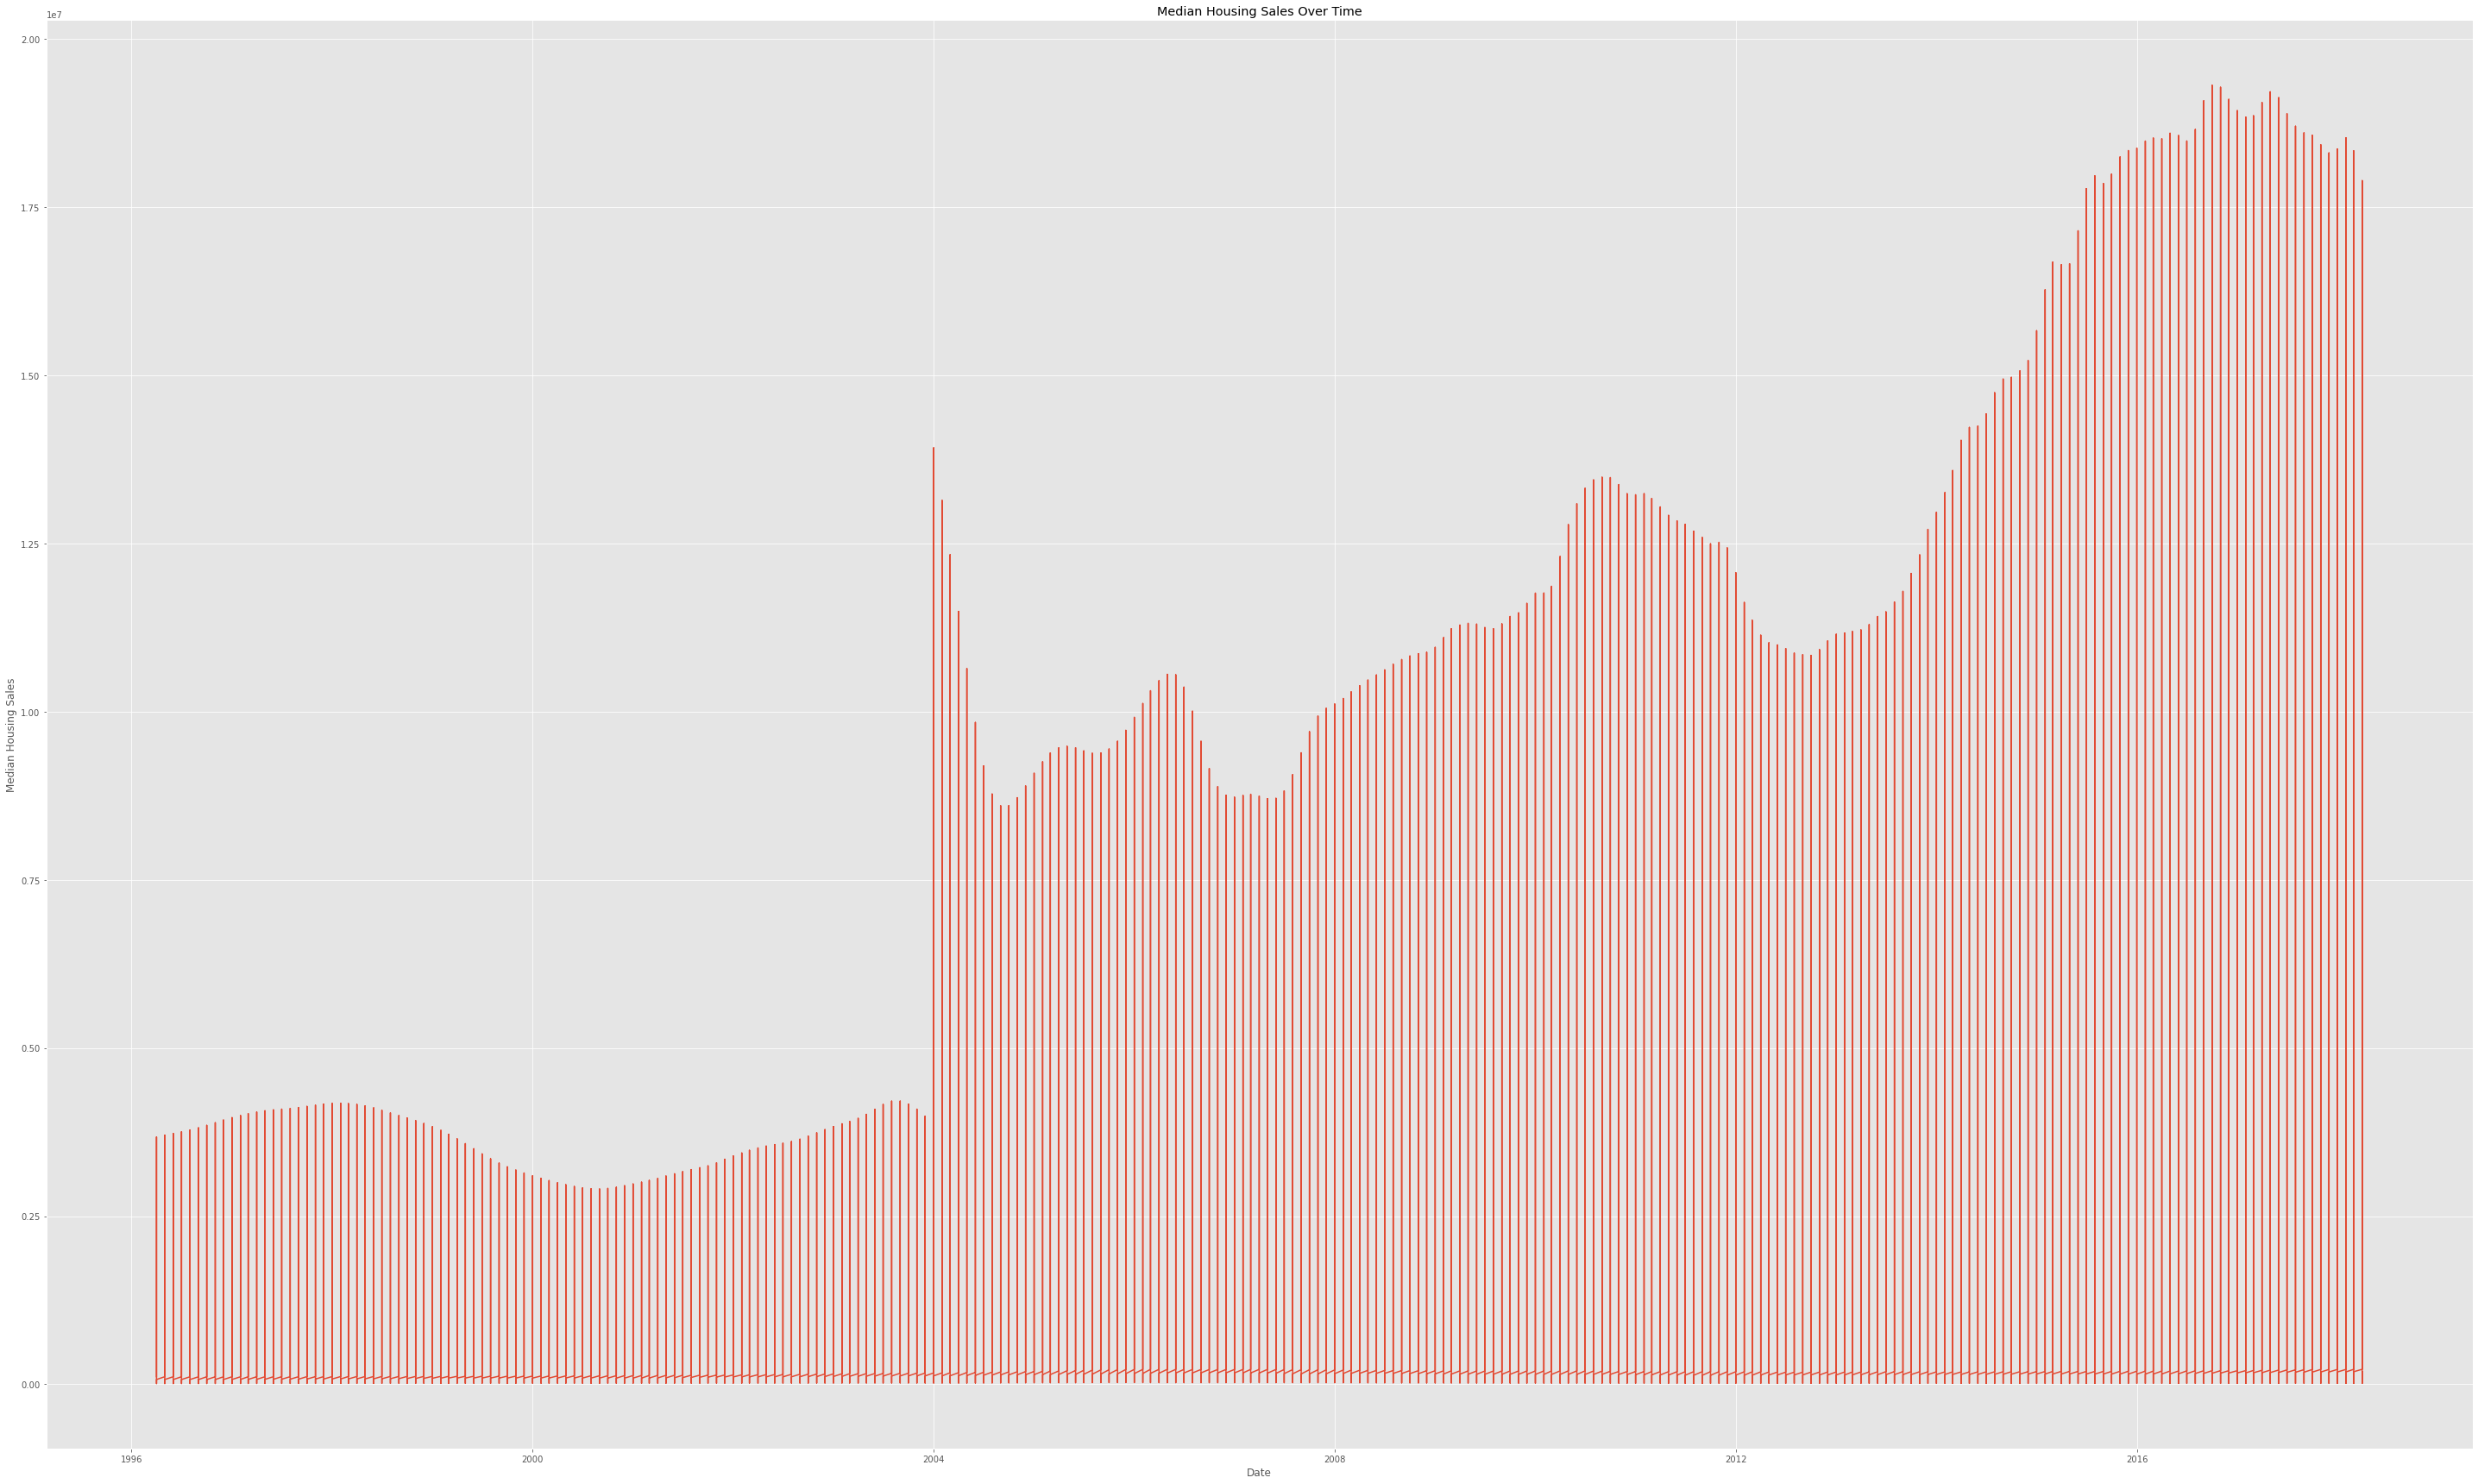

In [39]:
plt.figure(figsize=(40, 24))

# Plotting
plt.plot(final_df['Date'], final_df['MedianHousingSales'])

plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Median Housing Sales Over Time')
plt.tight_layout()  # Ensures proper spacing of the plot elements
plt.show()

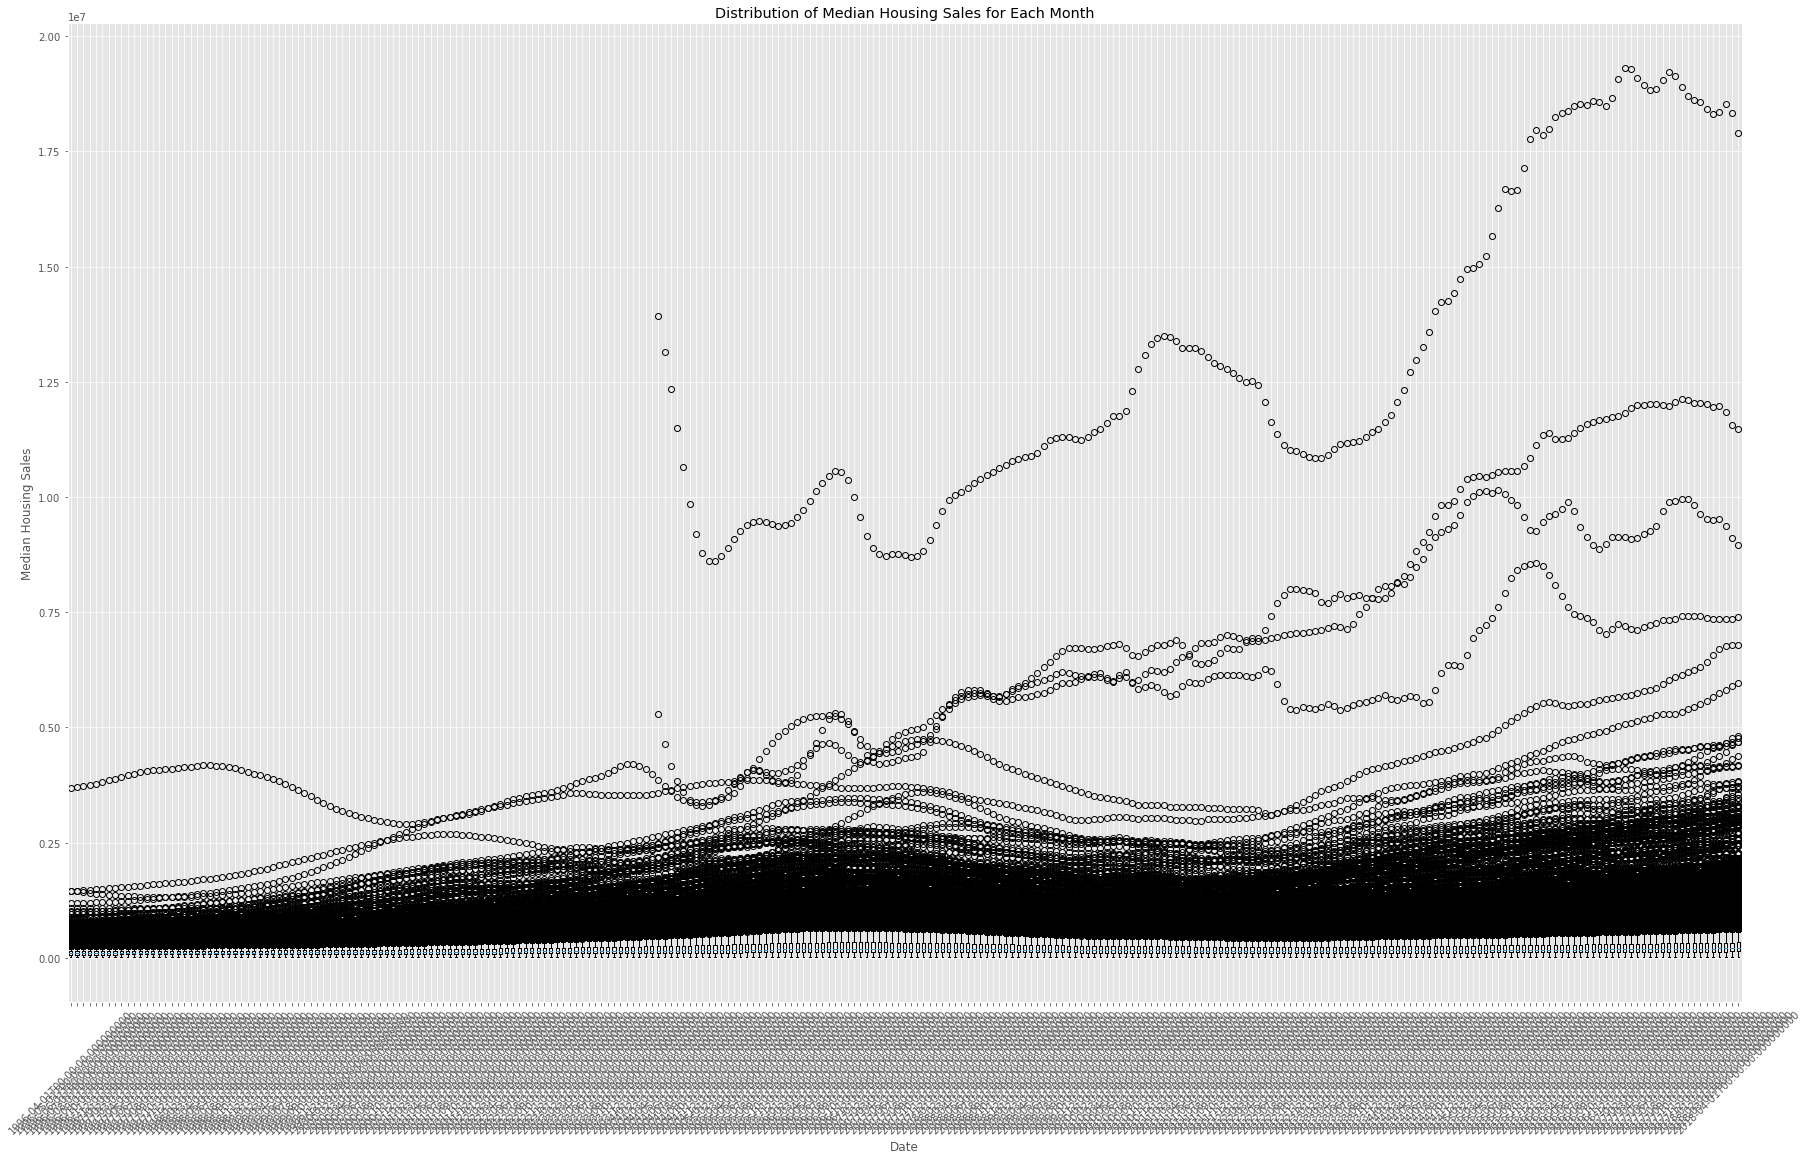

In [40]:
# Plotting
plt.figure(figsize=(30, 18))
plt.boxplot([final_df[final_df['Date'] == date]['MedianHousingSales'] for date in final_df['Date'].unique()],
            labels=final_df['Date'].unique())

plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Distribution of Median Housing Sales for Each Month')
plt.xticks(rotation=45)
plt.show()

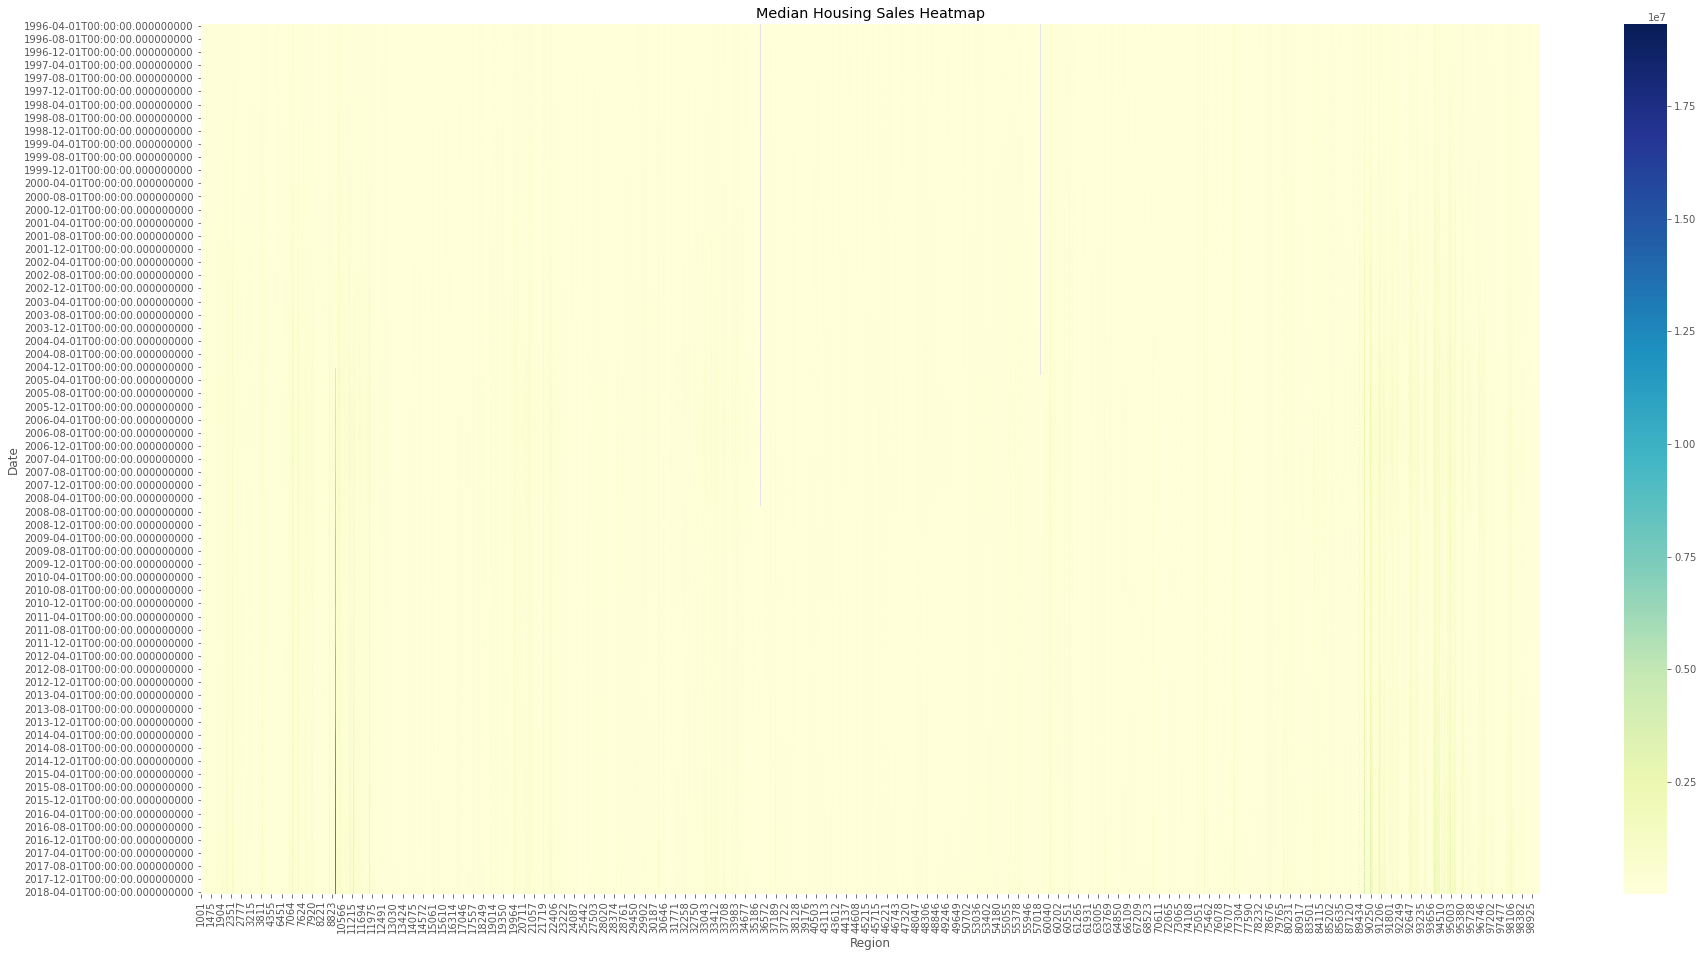

In [41]:
import seaborn as sns

# Pivot the data to create a pivot table with Date as index, RegionName as columns, and MedianHousingSales as values
pivot_df = final_df.pivot(index='Date', columns='RegionName', values='MedianHousingSales')

# Plotting
plt.figure(figsize=(30, 16))
sns.heatmap(pivot_df, cmap='YlGnBu')

plt.xlabel('Region')
plt.ylabel('Date')
plt.title('Median Housing Sales Heatmap')
plt.show()

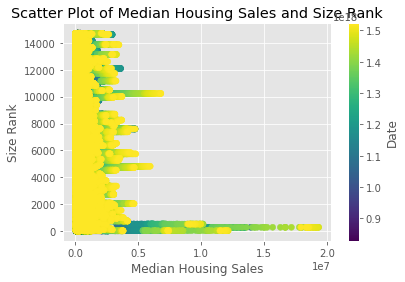

In [42]:
# Plotting
plt.scatter(final_df['MedianHousingSales'], final_df['SizeRank'], c=final_df['Date'], cmap='viridis')

plt.xlabel('Median Housing Sales')
plt.ylabel('Size Rank')
plt.title('Scatter Plot of Median Housing Sales and Size Rank')
plt.colorbar(label='Date')
plt.show()

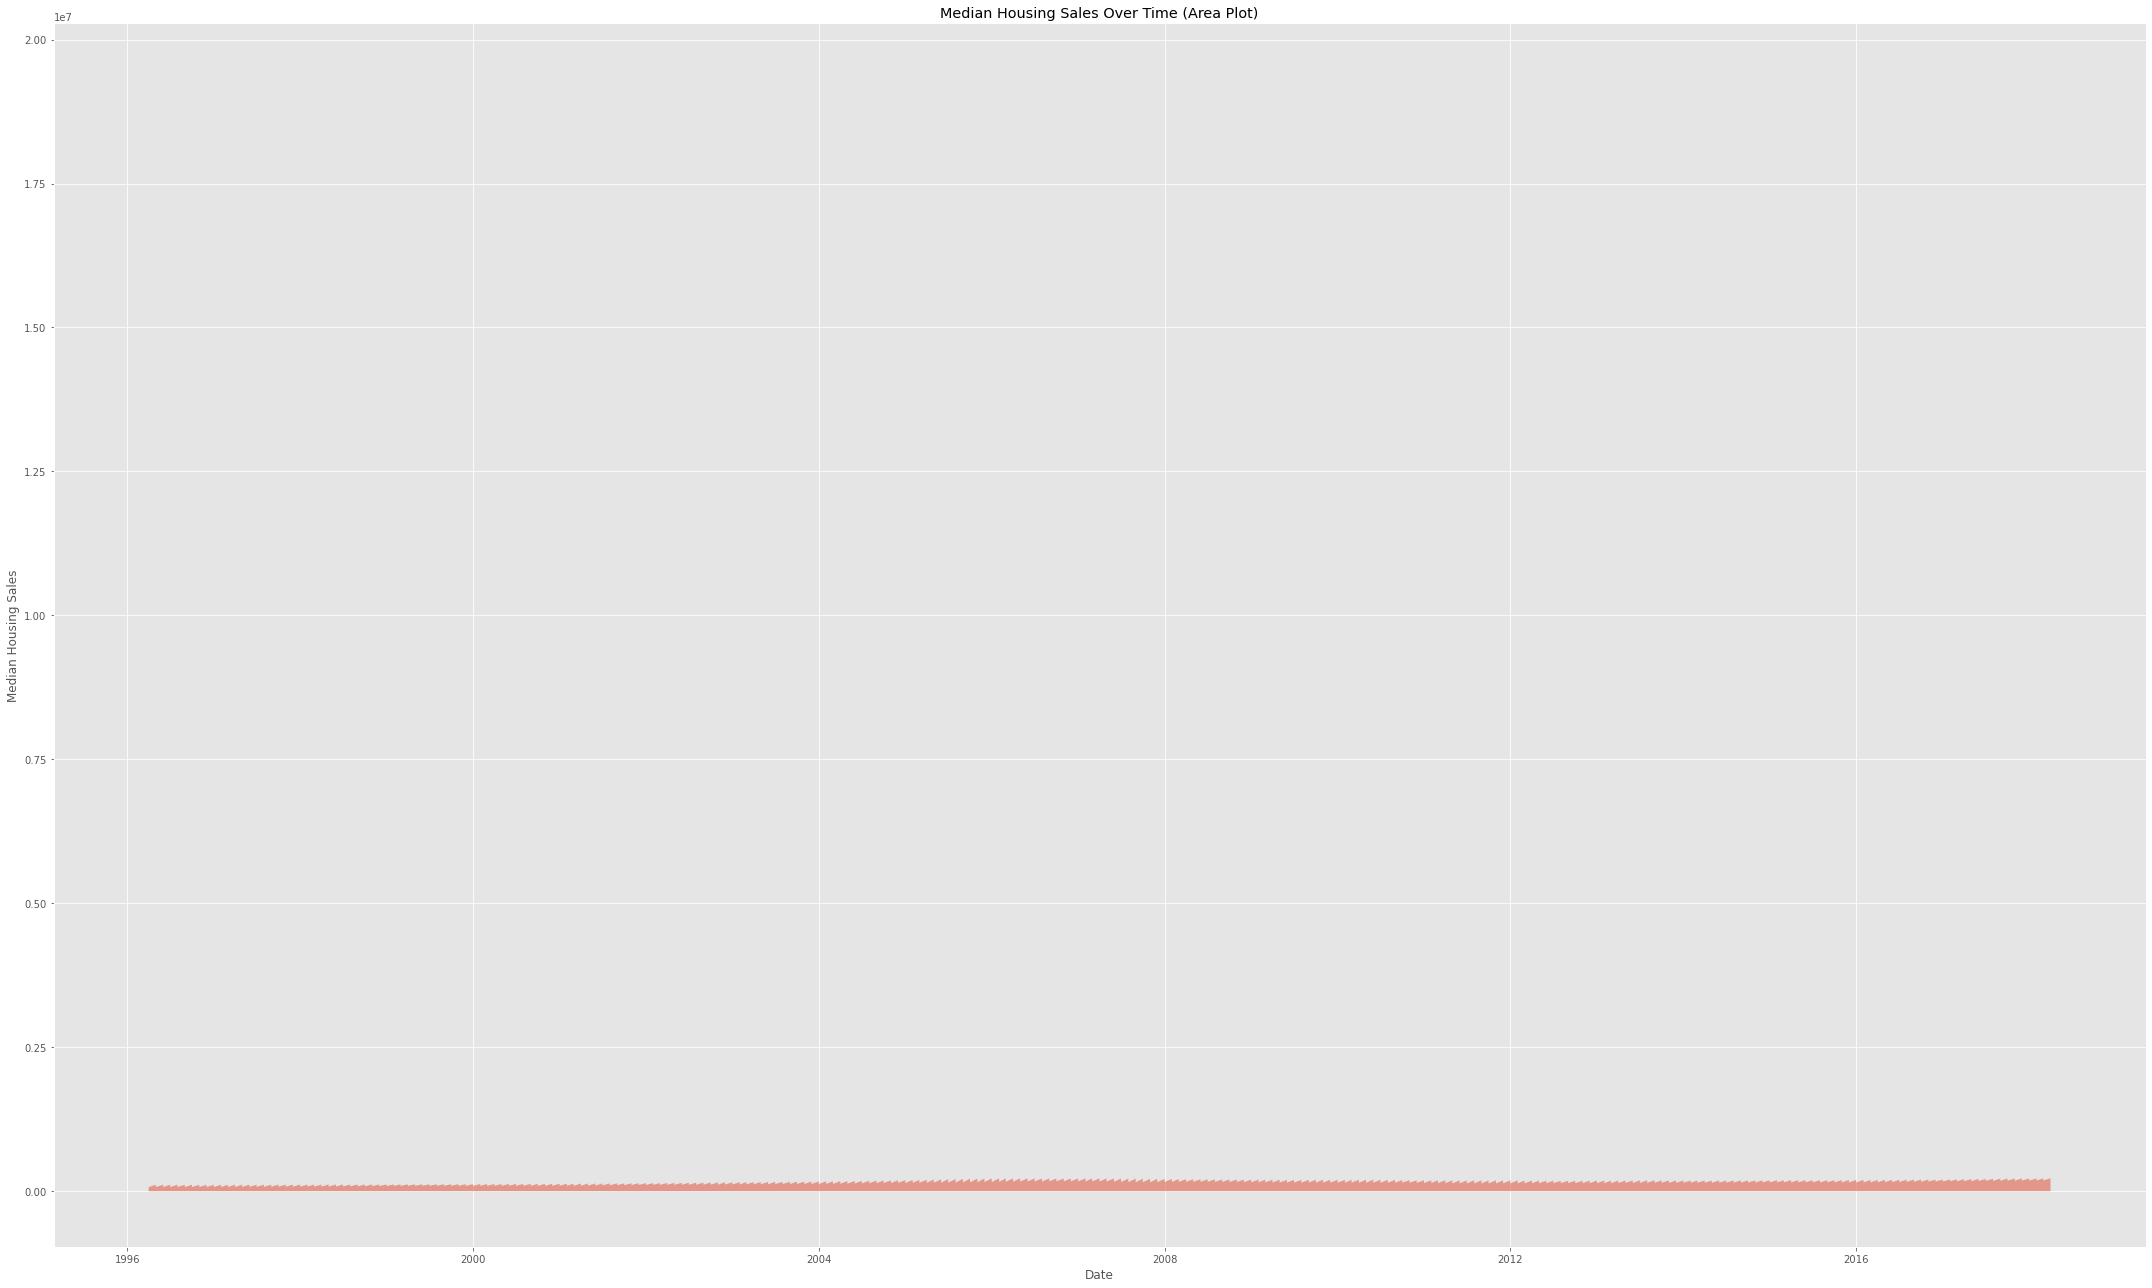

In [43]:
plt.figure(figsize=(30, 18))
plt.fill_between(final_df['Date'], final_df['MedianHousingSales'], alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Median Housing Sales Over Time (Area Plot)')
plt.tight_layout()
plt.show()

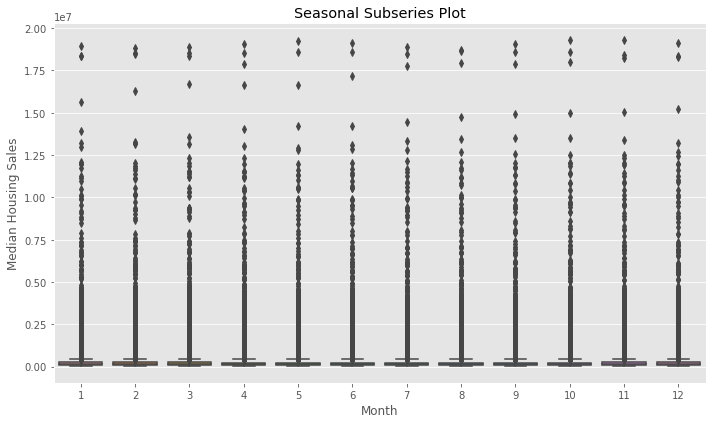

In [44]:
final_df['Month'] = final_df['Date'].dt.month

plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='MedianHousingSales', data=final_df)
plt.xlabel('Month')
plt.ylabel('Median Housing Sales')
plt.title('Seasonal Subseries Plot')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(final_df['Date'], final_df['MedianHousingSales'])
plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('Median Housing Sales Over Time (Bar Plot)')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

# Step 5: ARIMA Modeling

In [ ]:
model = ARIMA(final_df['MedianHousingSales'], order=(1, 0, 0))
model_fit = model.fit()

# Generate predictions
predictions = model_fit.predict(start=0, end=len(final_df)-1)

# Plot the original data and predictions
plt.figure(figsize=(10, 6))
plt.plot(final_df['Date'], final_df['MedianHousingSales'], label='Actual')
plt.plot(final_df['Date'], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Median Housing Sales')
plt.title('ARIMA Model')
plt.legend()
plt.tight_layout()
plt.show()

# Step 6: Interpreting Results